In [60]:
# import base libs
import pickle
import requests
import pandas as pd

In [61]:
# import for plotting
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely

In [23]:
# base URL
BASE_URL = 'https://recoil.ise.utk.edu/data/Parsed_Data/'

# Util functions

In [53]:
# Function to load a pickle file from a URL
def load_pickle_from_url(url):
    """
    Downloads and loads a pickle file from the specified URL.

    Parameters:
        url (str): The URL to the pickle file.

    Returns:
        object: The deserialized Python object.
    """
    try:
        response = requests.get(url, timeout=10)  # Set a timeout for the request
        response.raise_for_status()  # Raise an exception for HTTP errors
        return pickle.loads(response.content)  # Deserialize and return the object
    except requests.exceptions.RequestException as e:
        raise RuntimeError(f"Failed to download file from {url}: {e}")
    except pickle.UnpicklingError as e:
        raise RuntimeError(f"Failed to load pickle data: {e}")

In [76]:
def create_geoframe_from_edges(edges, plot=False):
    """
    Converts edge data into a GeoDataFrame and optionally plots it.

    Parameters:
        edges (dict): A dictionary containing edge data. Each key should be a tuple `(i, j)`
                      and the value should be a dictionary with keys 'path', 'i_lat', 'i_lon', 
                      'j_lat', 'j_lon', 'mode', and 'distance'.
        plot (bool): Whether to plot the resulting GeoDataFrame. Default is False.

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame containing the edge data with geometries.
    """
    # Create an empty DataFrame with the required columns
    geoframe = pd.DataFrame(columns=[
        'i', 'j', 'i_lat', 'i_lon', 'j_lat', 'j_lon', 'mode', 'distance', 'geometry'
    ])

    # Populate the DataFrame
    for key in edges:
        path = shapely.LineString([(e[1], e[0]) for e in edges[key]['path']])
        geoframe.loc[geoframe.shape[0]] = [
            key[0], key[1], edges[key]['i_lat'], edges[key]['i_lon'], edges[key]['j_lat'],
            edges[key]['j_lon'], edges[key]['mode'], edges[key]['distance'], path
        ]

    # Convert to GeoDataFrame
    geoframe = gpd.GeoDataFrame(geoframe, geometry=geoframe['geometry'])

    # Optionally plot the GeoDataFrame
    if plot:
        fig, ax = plt.subplots(figsize=(15, 10))
        geoframe.plot(ax=ax)
        plt.show()

    return geoframe

In [239]:
def filter_nodes_by_substring(df_nodes, column, substring):
    """
    Filters rows in a DataFrame where a specific column contains a given substring.

    Parameters:
        df_nodes (pd.DataFrame): The DataFrame to filter.
        column (str): The column to search in.
        substring (str): The substring to look for.

    Returns:
        pd.DataFrame: A filtered DataFrame containing rows where the column includes the substring.
    """
    return df_nodes[df_nodes[column].str.contains(substring, na=False)]


In [ ]:
def find_id_by_type(df, type_value):
    """
    Finds and returns the first ID where the type matches a given value.

    Parameters:
        df (pd.DataFrame): The DataFrame to search.
        type_value (str): The type value to match.

    Returns:
        int or None: The first ID where the type matches the given value, or None if no match is found.
    """
    result = df[df['type'] == type_value]['id']
    return result.iloc[0] if not result.empty else None

In [ ]:
def find_connection_by_id(keys, id):
    """
    Finds and returns all connections for a given ID, both starting and ending.

    Parameters:
        keys (list of tuples): List of edge tuples (start, end).
        id (int): The number to search for.

    Returns:
        list: A list of unique nodes connected to the given ID.
    """
    connections = [key[1] for key in keys if key[0] == id] + [key[0] for key in keys if key[1] == id]
    return list(set(connections))

# Selected Intermodal Nodes 
- 217 in total

In [51]:
url_N = f"{BASE_URL}intermodal-217.csv"

# Load the CSV file into a DataFrame
try:
    df_nodes = pd.read_csv(url_N)
except Exception as e:
    print(f"Failed to load CSV file: {e}")

In [52]:
df_nodes.head()

id        lat        lon type                             city  \
0  101  42.912500 -73.706569    R           Albany (Mechanicville)   
1  102  38.182031 -85.655462    R  Louisville, KY - Appliance Park   
2  103  33.794341 -84.439651    R                      Atlanta, GA   
3  104  42.547670 -71.591423    R                         Ayer, MA   
4  105  40.603163 -75.334250    R                    Bethlehem, PA   

                     Remarks  
0  Norfolk Southern Railroad  
1  Norfolk Southern Railroad  
2  Norfolk Southern Railroad  
3  Norfolk Southern Railroad  
4  Norfolk Southern Railroad

In [87]:
df_nodes.shape

(217, 6)

### Retrieve a node by its id

In [66]:
# show one node by id
df_nodes[df_nodes['id'] == 201]

id        lat        lon type            city        Remarks
56  201  30.686588 -88.038007    W  Port of Mobile  Alabama River

In [67]:
# show one node by id
df_nodes[df_nodes['id'] == 204]

id        lat        lon type                 city Remarks
59  204  33.736551 -118.26492    W  Port of Los Angeles     NaN

In [69]:
# show one node by id
df_nodes[df_nodes['id'] == 304]

id        lat        lon type         city Remarks
107  304  34.739207 -92.352548    H  Arkansas AR      AR

In [99]:
# show Atlanda
df_nodes[df_nodes['id'] == 103]

id        lat        lon type         city                    Remarks
2  103  33.794341 -84.439651    R  Atlanta, GA  Norfolk Southern Railroad

### Retrieve a node by city name

In [108]:
# show Seattle
df_nodes[df_nodes['city'].str.contains('Seattle', na=False)]

id        lat         lon type             city                  Remarks
37   138  47.561996 -122.331797    R          Seattle  Union Pacific Railroad 
99   244  47.586482 -122.352402    W  Port of Seattle                      NaN
199  396  47.613838 -122.354258    H       Seattle WA                       WA

-- note that there are three of them: H/R/W

In [109]:
# show New York
df_nodes[df_nodes['city'].str.contains('New York', na=False)]

id        lat        lon type                             city Remarks
85   230  40.692227 -74.181700    W  Port of New York and New Jersey     NaN
176  373  40.760532 -73.998152    H                 New York City NY      NY

In [110]:
# show Houston
df_nodes[df_nodes['city'].str.contains('Houston', na=False)]

id        lat        lon type             city                  Remarks
55   156  29.831782 -95.288641    R          Houston  Union Pacific Railroad 
96   241  29.610945 -95.021671    W  Port of Houston                      NaN
140  337  29.863478 -95.560839    H       Houston TX                       TX

# Demand data

In [210]:
# load demand data from pickle
url_D = f"{BASE_URL}demand.pickle"

demand = load_pickle_from_url(url_D)

In [211]:
len(demand.keys())

12656

In [212]:
# Retrieve demands of an O-D pair: 301 to 302
demand[(301, 302)]

{'tons_2025': 53.51673100000001,
 'tons_2030': 62.724078,
 'tons_2035': 73.209946,
 'tons_2040': 85.578652,
 'tons_2045': 100.22442199999999,
 'tons_2050': 113.33473199999999}

In [213]:
# Retrieve demands of an O-D pair: 301 to 302
demand[301, 302]

{'tons_2025': 53.51673100000001,
 'tons_2030': 62.724078,
 'tons_2035': 73.209946,
 'tons_2040': 85.578652,
 'tons_2045': 100.22442199999999,
 'tons_2050': 113.33473199999999}

In [214]:
# Retrieve demands of an O-D pair: 302 to 301
demand[302, 301]

{'tons_2025': 22.059051999999998,
 'tons_2030': 25.756860999999994,
 'tons_2035': 30.025526,
 'tons_2040': 35.395095999999995,
 'tons_2045': 41.96080500000001,
 'tons_2050': 48.646066000000005}

In [238]:
# show Atlanta -> Seattle

# !! wrong !!
# demand[103, 302]
# this fails because the demand notes must be the H (highway) nodes 

# and this works: # see code below on how to find the codes 305 and 396
demand[305, 396]

{'tons_2025': 162.232798,
 'tons_2030': 178.83615500000002,
 'tons_2035': 197.32954600000002,
 'tons_2040': 219.202123,
 'tons_2045': 245.318901,
 'tons_2050': 270.950343}

In [237]:
# Sample code to list the nodes of Atlanta
city = 'Atlanta'

filtered_nodes = filter_nodes_by_substring(df_nodes, 'city', city)
filtered_nodes

id        lat        lon type         city                    Remarks
2    103  33.794341 -84.439651    R  Atlanta, GA  Norfolk Southern Railroad
108  305  33.634122 -84.392255    H   Atlanta GA                         GA

In [233]:
# Sample code to list the nodes of Seattle
city = 'Seattle'

filtered_nodes = filter_nodes_by_substring(df_nodes, 'city', city)
filtered_nodes

id        lat         lon type             city                  Remarks
37   138  47.561996 -122.331797    R          Seattle  Union Pacific Railroad 
99   244  47.586482 -122.352402    W  Port of Seattle                      NaN
199  396  47.613838 -122.354258    H       Seattle WA                       WA

In [240]:
# demand

In [223]:
keys_d = demand.keys()

In [241]:
# find_connection_by_id(keys_d, 302)

# Water network

In [70]:
url_W = f"{BASE_URL}W-adj.pickle"

water = load_pickle_from_url(url_W)

In [71]:
# List a sample of 10 adjacent nodes
list(water.keys())[:10]

[(201, 204),
 (201, 205),
 (201, 208),
 (201, 217),
 (201, 218),
 (202, 225),
 (202, 228),
 (203, 226),
 (203, 234),
 (203, 240)]

In [72]:
# List the edges between two nodes
water[201, 204]

{'i_lat': 30.68658787,
 'i_lon': -88.03800749,
 'j_lat': 33.73655131,
 'j_lon': -118.2649202,
 'mode': 'R',
 'distance': 5391.220094356283,
 'path': ((30.68658787, -88.03800749),
  (30.686354527368547, -88.03577625176275),
  (30.686354527368547, -88.03577625176275),
  (30.67785436068853, -88.03672491476351),
  (30.667294362752287, -88.0316749164158),
  (30.656772406537538, -88.0318419536253),
  (30.656772406537538, -88.0318419536253),
  (30.645559367287316, -88.03201991650654),
  (30.645559367287316, -88.03201991650654),
  (30.614914375063456, -88.03289091802485),
  (30.596174378515762, -88.03069491922001),
  (30.54606438867033, -88.02428492336998),
  (30.52447439336842, -88.02265492577007),
  (30.52447439336842, -88.02265492577007),
  (30.47928540409211, -88.01762892778642),
  (30.47928540409211, -88.01762892778642),
  (30.44594441062214, -88.01349493077423),
  (30.271497449548633, -88.03579793268794),
  (30.271497449548633, -88.03579793268794),
  (30.244155457148626, -88.039630932805

## Display the geometry & plot it

In [79]:
geoframe = create_geoframe_from_edges(water, plot=True)


In [78]:
print(geoframe.head())

     i    j      i_lat      i_lon      j_lat       j_lon mode     distance  \
0  201  204  30.686588 -88.038007  33.736551 -118.264920    R  5391.220094   
1  201  205  30.686588 -88.038007  37.795666 -122.279131    R  5858.492875   
2  201  208  30.686588 -88.038007  27.950394  -82.444975    R   485.635629   
3  201  217  30.686588 -88.038007  29.937141  -90.061313    R   162.072382   
4  201  218  30.686588 -88.038007  30.434651  -91.201457    R   295.212361   

                                            geometry  
0  LINESTRING (-88.03801 30.68659, -88.03578 30.6...  
1  LINESTRING (-88.03801 30.68659, -88.03578 30.6...  
2  LINESTRING (-88.03801 30.68659, -88.03578 30.6...  
3  LINESTRING (-88.03801 30.68659, -88.03578 30.6...  
4  LINESTRING (-88.03801 30.68659, -88.03578 30.6...  


# Highway network

In [43]:
# Note that this file is about 4GB. So, it could take a while depending on your network.
url_H = f"{BASE_URL}H-adj.pickle"

highway = load_pickle_from_url(url_H)

In [44]:
# List a sample of 10 adjacent nodes
list(highway.keys())[:10]

[(101, 102),
 (101, 103),
 (101, 104),
 (101, 105),
 (101, 106),
 (101, 107),
 (101, 108),
 (101, 109),
 (101, 110),
 (101, 111)]

In [46]:
# List the edges between two nodes
highway[101, 102]

{'i_lat': 42.91249982,
 'i_lon': -73.70656896,
 'j_lat': 38.18203089,
 'j_lon': -85.65546202,
 'mode': 'H',
 'distance': 807.6975515600011,
 'path': ((42.91249982, -73.70656896),
  (42.91476399995361, -73.70538000048593),
  (42.91476399995361, -73.70538000048593),
  (42.91490899995682, -73.7058320005923),
  (42.915621999854004, -73.70776799960055),
  (42.916164999724266, -73.70923499960378),
  (42.916544000344494, -73.71008500024182),
  (42.916700000426545, -73.71039200009564),
  (42.91694500002091, -73.71083400044148),
  (42.91784000047088, -73.71236500013838),
  (42.91812499999727, -73.7128229998919),
  (42.9182929995557, -73.71311599969067),
  (42.9184920002125, -73.71354799998093),
  (42.91869200000119, -73.71404599978403),
  (42.91885599969521, -73.71459500066891),
  (42.91934900023599, -73.71623600036814),
  (42.919844999937524, -73.71791300059417),
  (42.9199140001383, -73.71818000003974),
  (42.919971999835695, -73.71854100049265),
  (42.92000599997621, -73.7189529995761),
  (4

## Display the geometry & plot it

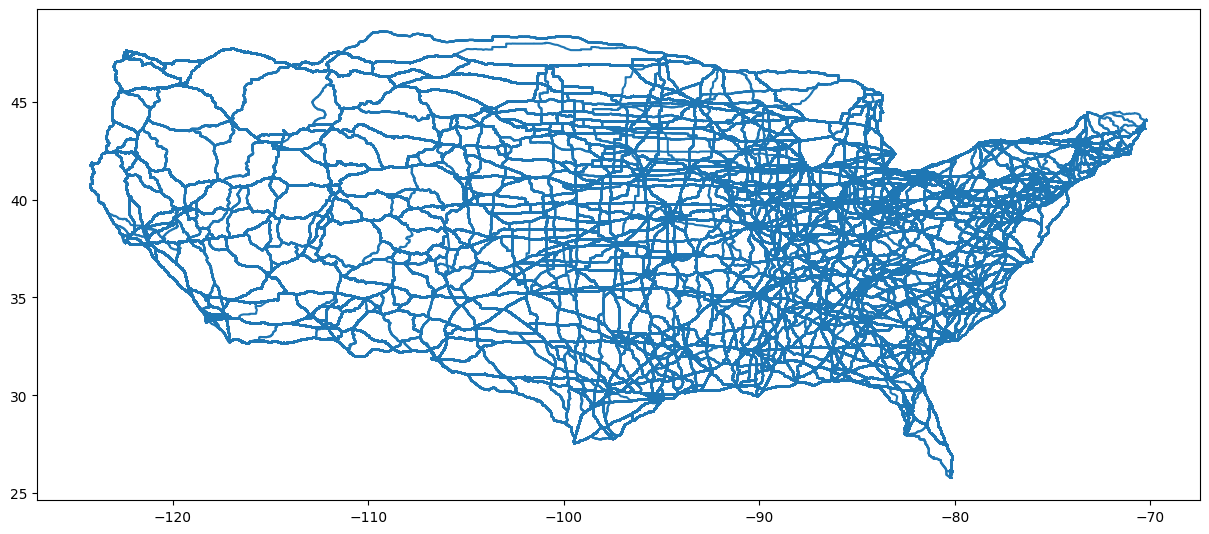

In [84]:
# note this takes a while to plot! 
geoframe = create_geoframe_from_edges(highway, plot=True)


In [85]:
print(geoframe.head())

     i    j    i_lat      i_lon      j_lat      j_lon mode    distance  \
0  101  102  42.9125 -73.706569  38.182031 -85.655462    H  807.697552   
1  101  103  42.9125 -73.706569  33.794341 -84.439651    H  978.197415   
2  101  104  42.9125 -73.706569  42.547670 -71.591423    H  144.188756   
3  101  105  42.9125 -73.706569  40.603163 -75.334250    H  204.681599   
4  101  106  42.9125 -73.706569  42.891732 -78.783031    H  279.895559   

                                            geometry  
0  LINESTRING (-73.70657 42.91250, -73.70538 42.9...  
1  LINESTRING (-73.70657 42.91250, -73.70538 42.9...  
2  LINESTRING (-73.70657 42.91250, -73.70538 42.9...  
3  LINESTRING (-73.70657 42.91250, -73.70538 42.9...  
4  LINESTRING (-73.70657 42.91250, -73.70538 42.9...  


In [86]:
geoframe.shape

(23436, 9)

# Rail network

In [36]:
url_R = f"{BASE_URL}R-adj.pickle"

rail = load_pickle_from_url(url_R)

In [37]:
# List a sample of 10 adjacent nodes
list(rail.keys())[:10]

[(101, 104),
 (101, 106),
 (101, 114),
 (101, 128),
 (102, 112),
 (102, 117),
 (102, 127),
 (103, 111),
 (103, 116),
 (103, 117)]

In [38]:
# List the edges between two nodes
rail[102, 117]

{'i_lat': 42.91249982,
 'i_lon': -73.70656896,
 'j_lat': 42.54767027,
 'j_lon': -71.59142259,
 'mode': 'R',
 'distance': 151.7830747252351,
 'path': ((42.91249982, -73.70656896),
  (42.90901643844719, -73.69606643516566),
  (42.90901643844719, -73.69606643516566),
  (42.90889124301554, -73.69573536198187),
  (42.90880836509108, -73.69551619433825),
  (42.90880836509108, -73.69551619433825),
  (42.90853523676216, -73.69493717282133),
  (42.90824681131887, -73.6943257225171),
  (42.90813020359743, -73.6941263757168),
  (42.90784560821097, -73.69363367589871),
  (42.90764330991975, -73.69322365124019),
  (42.907573426562536, -73.69308200780632),
  (42.907562087591124, -73.69302741772002),
  (42.907548583910355, -73.69296239273116),
  (42.90744001640781, -73.69243447151938),
  (42.90739131452305, -73.69214851281308),
  (42.907356664690234, -73.6918020246791),
  (42.90734051423402, -73.6916181524586),
  (42.90733290494063, -73.69132896113531),
  (42.90732681940758, -73.69109778588026),
  (4

## Display the geometry & plot it

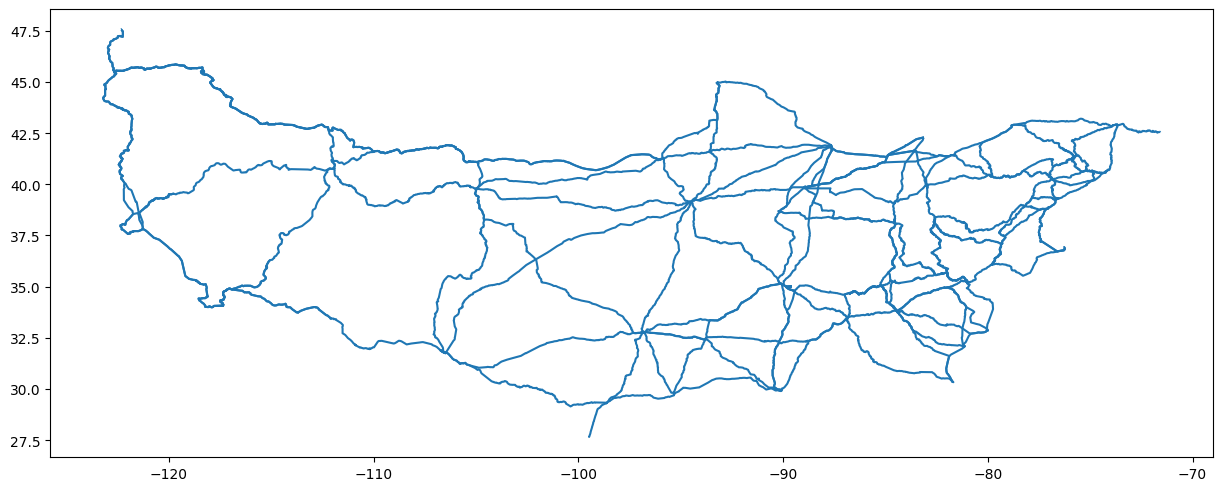

In [82]:
geoframe = create_geoframe_from_edges(rail, plot=True)

In [83]:
print(geoframe.head())

     i    j      i_lat      i_lon      j_lat      j_lon mode    distance  \
0  101  104  42.912500 -73.706569  42.547670 -71.591423    R  151.783075   
1  101  106  42.912500 -73.706569  42.891732 -78.783031    R  290.339293   
2  101  114  42.912500 -73.706569  40.685949 -74.162958    R  173.363328   
3  101  128  42.912500 -73.706569  41.386521 -75.704576    R  206.526990   
4  102  112  38.182031 -85.655462  39.873635 -88.911973    R  292.885685   

                                            geometry  
0  LINESTRING (-73.70657 42.91250, -73.69607 42.9...  
1  LINESTRING (-73.70657 42.91250, -73.69607 42.9...  
2  LINESTRING (-73.70657 42.91250, -73.69607 42.9...  
3  LINESTRING (-73.70657 42.91250, -73.69607 42.9...  
4  LINESTRING (-85.65546 38.18203, -85.65362 38.1...  


In [98]:
geoframe.shape

(23436, 9)

# Advanced 


## find a city, e.g. Houston, and its intermodal neighhors (R/W)

In [137]:
# find Houston

city = 'Houston'

filtered_nodes = filter_nodes_by_substring(df_nodes, 'city', 'Houston')
filtered_nodes

id        lat        lon type             city                  Remarks
55   156  29.831782 -95.288641    R          Houston  Union Pacific Railroad 
96   241  29.610945 -95.021671    W  Port of Houston                      NaN
140  337  29.863478 -95.560839    H       Houston TX                       TX

In [195]:
# my id in water nodes
id = find_id_by_type(filtered_nodes, 'W')
id

241

In [196]:
# all the key pairs
keys_w = list(water.keys())
# keys_w

In [198]:
# what are my neighhors via the water network?
nei_w = find_connection_by_id(keys_w, id)
nei_w

[242, 219, 204, 205]

In [201]:
# who are these nodes?
for e in nei_w:
    print(df_nodes[df_nodes['id'] == e]['city'])

97    Port of Corpus Christi
Name: city, dtype: object
74    Port of Lake Charles
Name: city, dtype: object
59    Port of Los Angeles
Name: city, dtype: object
60    Port of Oakland
Name: city, dtype: object


In [202]:
# my id in rail network
id = find_id_by_type(filtered_nodes, 'R')
id

156

In [204]:
# all the key pairs
keys_r = list(rail.keys())
# keys_r

In [205]:
# what are my neighhors via the rail network?
nei_r = find_connection_by_id(keys_r, id)
nei_r

[137, 154, 133, 126]

In [206]:
# who are these nodes?
for e in nei_r:
    print(df_nodes[df_nodes['id'] == e]['city'])

36    Dallas
Name: city, dtype: object
53    San Antonio
Name: city, dtype: object
32    New Orleans, LA  
Name: city, dtype: object
25    Memphis, TN-rossville
Name: city, dtype: object


In [181]:
# highway - fully connected | so, no need to do this
id = find_id_by_type(filtered_nodes, 'H')
id

337

In [184]:
keys_h = list(highway.keys())
# keys_h

In [186]:
# what are my neighhors via the hight network?
edges = find_connection_by_id(keys_h, id)
# edges